In [148]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_fontja
import joblib

In [149]:
# Excelデータの読み込み
file_path_4 = './data/【4月予測用】出荷リソース記入用紙.xlsx'  # Excelファイルのパスを指定
sheet_name = '実績昼'  # 読み込むシート名を指定

data_4 = pd.read_excel(file_path_4, sheet_name=sheet_name)
data_4.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,作業ライン,項目,2024-09-01 00:00:00,2024-09-02 00:00:00,2024-09-03 00:00:00,2024-09-04 00:00:00,2024-09-05 00:00:00,2024-09-06 00:00:00,2024-09-07 00:00:00,2024-09-08 00:00:00,...,2024-09-24 00:00:00,2024-09-25 00:00:00,2024-09-26 00:00:00,2024-09-27 00:00:00,2024-09-28 00:00:00,2024-09-29 00:00:00,2024-09-30 00:00:00,1900-01-31 00:00:00,2024-10-01,合計
2,NaN,日付,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,NaT,NaN
3,A-PaLS,件数,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,NaN,作業時間(分),NaN,NaN,NaN,4680,1872,NaN,2340,7371,...,7371,7371,NaN,NaN,7371,NaN,7371,NaN,NaT,NaN


In [150]:
def clean_logistics_data(file_path, sheet_name):

    # データ読み込み
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # 転置
    df = df.T

    # 1行目をカラム名にして削除
    df.columns = df.iloc[1]
    df = df.drop(df.index[[0, 1]])

    # 「項目」列がある2列目以降を抽出（1列目は"作業ライン"、2列目が"項目"）
    df_section = df.iloc[1:10, 1:21]  # 2行目〜10行目、2列目〜21列目（日付1〜20）

    # 最初の列をインデックス（項目名）として、列を日付とするように転置
    df_section.columns = df_section.iloc[0]  # 2行目（"件数"など）をカラム名にする
    df_section = df_section.drop(df_section.index[0])  # カラム名に使った行を削除

    # 行番号を日付（1〜20）にして分かりやすく
    df_section = df_section.reset_index(drop=True)
    df_section.insert(0, "日付", range(1, len(df_section) + 1))


    # 削除対象のカラム名
    columns_to_drop = [
        np.nan,
        'テイケイ',
        '目標件数',
        '予測',
        '1本あたりの平均作業数',
        '1本あたりの平均作業', 
        '1日あたりの作業件数',
        '買い合わせ平均',      
        '項目',
        '生産性(分/件)',
        '1日作業量/L'
    ]

    # 一致するカラムのみ削除
    df = df.drop(columns=[col for col in df.columns if col in columns_to_drop])

    # 欠損値を0で埋める
    df = df.fillna(0)

    # 34行目（インデックス33）を削除
    df.drop(df.index[[31]])

    # 「件数」が0の行を削除（数値変換してから）
    if '件数' in df.columns:
        df['件数'] = pd.to_numeric(df['件数'], errors='coerce').fillna(0)
        df = df[df['件数'] != 0]

    return df


In [151]:
file_path_10 = './data/【10月】分析+day.xlsx'  # Excelファイルのパスを指定

In [152]:
file_path_9 = './data/【9月】分析+day.xlsx'  # Excelファイルのパスを指定

In [153]:
clean_logistics_data(file_path_10, sheet_name)

/var/folders/zn/w212lcms0dxb2bg4lyzl6pxm0000gn/T/ipykernel_4270/3126460726.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Unnamed: 1,日付,件数,作業時間(分),作業人数,リーダー人数,合計作業人数,作業ライン,1人あたりの作業時間
Unnamed: 3,2,1756,4302,7,5,12,4,358.500000
Unnamed: 4,3,2125,4740,6,6,12,4,395.000000
Unnamed: 5,4,2433,7002,12,6,18,6,389.000000
Unnamed: 6,5,1490,4620,13,2,15,5,308.000000
Unnamed: 8,7,2455,5544,11,4,15,5,369.600000
Unnamed: 9,8,2921,7026,18,3,21,7,334.571429
Unnamed: 10,9,2138,7905,17,4,21,7,376.428571
Unnamed: 11,10,1921,7332,17,4,21,7,349.142857
Unnamed: 12,11,2197,7491,17,4,21,7,356.714286
Unnamed: 13,12,1978,5634,16,2,18,6,313.000000


In [ ]:
def clean_resource_data(file_path, sheet_name='実績昼'):
    # Excelデータ読み込み
    data = pd.read_excel(file_path, sheet_name=sheet_name)

    # 行列を逆にして1行目を列名に
    data = data.T
    data.columns = data.iloc[1]
    data = data.drop(data.index[[0, 1]])

    # 不要な列を削除（例: 最初の2列と10, 11列目）
    data = data.drop(data.columns[[0, 1, 10, 11]], axis=1)

    # NaN を 0 に変換
    data = data.fillna(0)

    # 不要な行（31, 32行目）を削除
    data = data.drop(data.index[[31, 32]])

    # 「作業時間」を含む列を抽出
    work_time_cols = [col for col in data.columns if '作業時間' in str(col)]

   
    # いずれかの作業時間列が0の行を削除
    data = data[~(data[work_time_cols] == 0).any(axis=1)]

    return data


In [155]:
clean_resource_data(file_path_4, sheet_name)

/var/folders/zn/w212lcms0dxb2bg4lyzl6pxm0000gn/T/ipykernel_4270/3228135467.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(0)


Unnamed: 1,日付,件数,作業時間(分),作業人数,リーダー人数,合計作業人数,作業ライン,1人あたりの作業時間
Unnamed: 5,4,0,4680,12,3,15,5,312
Unnamed: 6,5,0,1872,4,2,6,2,312
Unnamed: 8,7,0,2340,3,3,6,2,390
Unnamed: 9,8,0,7371,19,2,21,7,351
Unnamed: 10,9,0,7371,18,3,21,7,351
Unnamed: 11,10,0,7371,19,2,21,7,351
Unnamed: 12,11,0,7371,18,3,21,7,351
Unnamed: 13,12,0,5265,13,2,15,5,351
Unnamed: 15,14,0,7371,18,3,21,7,351
Unnamed: 16,15,0,7371,19,2,21,7,351


In [156]:
# 行列を逆にする
data_4 = data_4.T
# 1行目を列名にする
data_4.columns = data_4.iloc[1]
# 0,1行目を削除
data_4 = data_4.drop(data_4.index[[0, 1]])
data_4.head()

Unnamed: 1,NaN,項目,日付,件数,作業時間(分),作業人数,リーダー人数,合計作業人数,作業ライン,1人あたりの作業時間,1本あたりの平均作業数,1日あたりの作業件数
Unnamed: 2,NaN,2024-09-01 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 3,NaN,2024-09-02 00:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 4,NaN,2024-09-03 00:00:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 5,NaN,2024-09-04 00:00:00,4,NaN,4680,12,3,15,5,312,NaN,NaN
Unnamed: 6,NaN,2024-09-05 00:00:00,5,NaN,1872,4,2,6,2,312,NaN,NaN


In [157]:
data_4 = data_4.drop(data_4.columns[[0, 1, 10,11]], axis=1)
data_4.head()

Unnamed: 1,日付,件数,作業時間(分),作業人数,リーダー人数,合計作業人数,作業ライン,1人あたりの作業時間
Unnamed: 2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 5,4,NaN,4680,12,3,15,5,312
Unnamed: 6,5,NaN,1872,4,2,6,2,312


In [158]:
# NaNを全て0に変換
data_4 = data_4.fillna(0)
data_4.head()

/var/folders/zn/w212lcms0dxb2bg4lyzl6pxm0000gn/T/ipykernel_4270/4077402185.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_4 = data_4.fillna(0)


Unnamed: 1,日付,件数,作業時間(分),作業人数,リーダー人数,合計作業人数,作業ライン,1人あたりの作業時間
Unnamed: 2,1,0,0,0,0,0,0,0
Unnamed: 3,2,0,0,0,0,0,0,0
Unnamed: 4,3,0,0,0,0,0,0,0
Unnamed: 5,4,0,4680,12,3,15,5,312
Unnamed: 6,5,0,1872,4,2,6,2,312


In [159]:
# Unnamed: 33と34を削除
data_4 = data_4.drop(data_4.index[[31, 32]])
data_4

Unnamed: 1,日付,件数,作業時間(分),作業人数,リーダー人数,合計作業人数,作業ライン,1人あたりの作業時間
Unnamed: 2,1,0,0,0,0,0,0,0
Unnamed: 3,2,0,0,0,0,0,0,0
Unnamed: 4,3,0,0,0,0,0,0,0
Unnamed: 5,4,0,4680,12,3,15,5,312
Unnamed: 6,5,0,1872,4,2,6,2,312
Unnamed: 7,6,0,0,0,0,0,0,0
Unnamed: 8,7,0,2340,3,3,6,2,390
Unnamed: 9,8,0,7371,19,2,21,7,351
Unnamed: 10,9,0,7371,18,3,21,7,351
Unnamed: 11,10,0,7371,19,2,21,7,351


In [160]:
# データの標準偏差及び平均を取得（正規化解除に使用）
original_mean_4 = data_4.mean()
original_std_4 = data_4.std()
print(original_mean_4)
print(original_std_4)

Unnamed: 1
日付              16.000000
件数               0.000000
作業時間(分)       4332.774194
作業人数             9.870968
リーダー人数           1.645161
合計作業人数          11.516129
作業ライン            3.838710
1人あたりの作業時間     367.354839
dtype: float64
Unnamed: 1
日付               9.092121
件数               0.000000
作業時間(分)       3334.874088
作業人数             8.666956
リーダー人数           1.305077
合計作業人数           9.708659
作業ライン            3.236220
1人あたりの作業時間     580.368765
dtype: float64


In [161]:
data_4 = data_4.apply(lambda x: np.log(x + 1))

In [162]:
X_test = data_4.drop(columns='件数', errors='ignore')
y_test = data_4['件数']

In [163]:
# 保存したモデルをロード
best_model = joblib.load("warehouse_model.pkl")

print("Model loaded successfully.")


Model loaded successfully.


In [164]:
print(X_test)

Unnamed: 1         日付   作業時間(分)      作業人数    リーダー人数    合計作業人数     作業ライン  \
Unnamed: 2   0.693147  0.000000  0.000000  0.000000  0.000000  0.000000   
Unnamed: 3   1.098612  0.000000  0.000000  0.000000  0.000000  0.000000   
Unnamed: 4   1.386294  0.000000  0.000000  0.000000  0.000000  0.000000   
Unnamed: 5   1.609438  8.451267  2.564949  1.386294  2.772589  1.791759   
Unnamed: 6   1.791759  7.535297  1.609438  1.098612  1.945910  1.098612   
Unnamed: 7   1.945910  0.000000  0.000000  0.000000  0.000000  0.000000   
Unnamed: 8   2.079442  7.758333  1.386294  1.386294  1.945910  1.098612   
Unnamed: 9   2.197225  8.905444  2.995732  1.098612  3.091042  2.079442   
Unnamed: 10  2.302585  8.905444  2.944439  1.386294  3.091042  2.079442   
Unnamed: 11  2.397895  8.905444  2.995732  1.098612  3.091042  2.079442   
Unnamed: 12  2.484907  8.905444  2.944439  1.386294  3.091042  2.079442   
Unnamed: 13  2.564949  8.569026  2.639057  1.098612  2.772589  1.791759   
Unnamed: 14  2.639057  0.

In [165]:
# 全てのデータに対して
# 予測を行う
y_pred = best_model.predict(X_test)

# 予測結果を元に戻す
y_pred_original = np.exp(y_pred)


# 各インデックスごとに比較結果を表示
for i in range(len(X_test)):
    print(f'Predicted: {y_pred_original[i]}')

Predicted: 275.24014918214317
Predicted: 275.24014918214317
Predicted: 275.24014918214317
Predicted: 1963.5251175426256
Predicted: 592.7314926288888
Predicted: 275.24014918214317
Predicted: 639.4523215161026
Predicted: 2341.202105019018
Predicted: 2343.3810683157976
Predicted: 2341.202105019018
Predicted: 2343.3810683157976
Predicted: 1937.288157791354
Predicted: 275.24014918214317
Predicted: 2343.3810683157976
Predicted: 2346.5157978999828
Predicted: 2301.2389820324297
Predicted: 2288.4821547828133
Predicted: 2296.1921517885125
Predicted: 1925.4697814670565
Predicted: 275.24014918214317
Predicted: 2343.548790656303
Predicted: 2409.4985212477095
Predicted: 2488.135727126465
Predicted: 2467.1147995078536
Predicted: 2488.135727126465
Predicted: 275.24014918214317
Predicted: 275.24014918214317
Predicted: 818.2734899171172
Predicted: 275.24014918214317
Predicted: 808.124153125792
Predicted: 239.48609889301795


In [166]:
print(y_pred_original)

[ 275.24014918  275.24014918  275.24014918 1963.52511754  592.73149263
  275.24014918  639.45232152 2341.20210502 2343.38106832 2341.20210502
 2343.38106832 1937.28815779  275.24014918 2343.38106832 2346.5157979
 2301.23898203 2288.48215478 2296.19215179 1925.46978147  275.24014918
 2343.54879066 2409.49852125 2488.13572713 2467.11479951 2488.13572713
  275.24014918  275.24014918  818.27348992  275.24014918  808.12415313
  239.48609889]


In [167]:
# 特徴量重要度を表示
feature_importances = best_model.feature_importances_
features = data_4.drop(columns='件数', errors='ignore').columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df = df.sort_values(by='importance', ascending=False)
df

,features,importance
1,作業時間(分),0.389588
2,作業人数,0.177474
4,合計作業人数,0.146600
5,作業ライン,0.138500
6,1人あたりの作業時間,0.114693
0,日付,0.031464
3,リーダー人数,0.001681


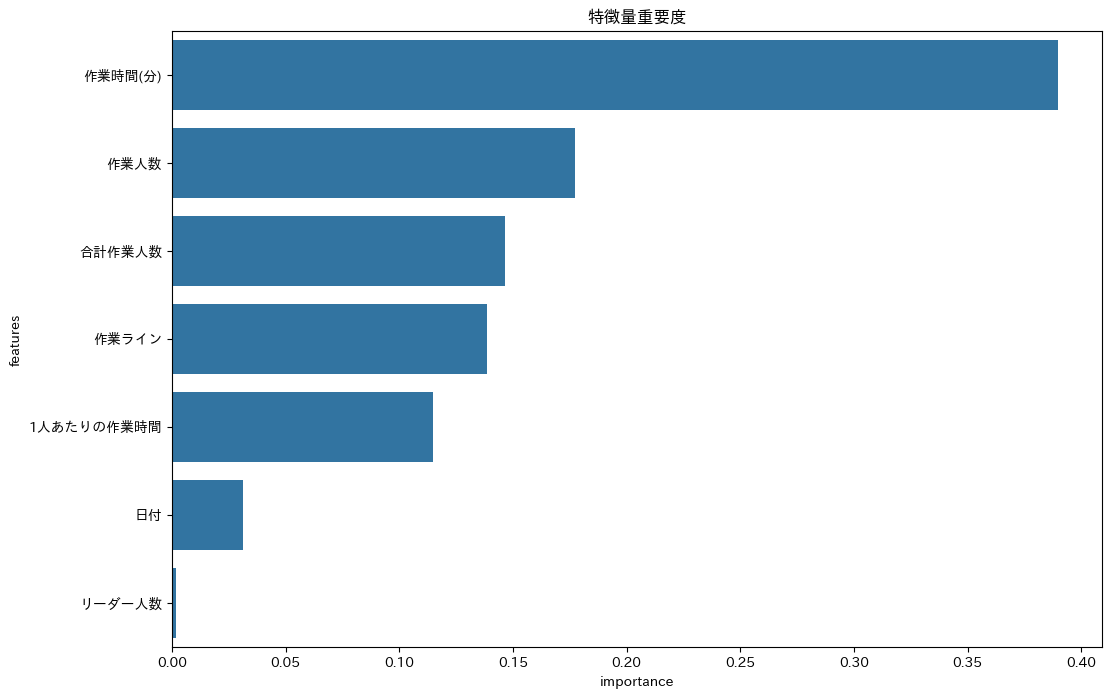

In [168]:
# 特徴量重要度を可視化

import matplotlib.pyplot as plt 
import seaborn as sns
import japanize_matplotlib
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='features', data=df)
plt.title('特徴量重要度')
plt.show()